# Let's make a full neural network using just NumPy!

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

### Simple binary classification dataset

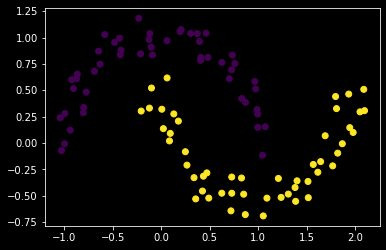

In [33]:
X, Y = make_moons(noise=0.1)
Y = np.expand_dims(Y, 1)
plt.style.use('dark_background')
plt.scatter(X.T[0], X.T[1], c=Y)
plt.show()

### Activation functions

In [34]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    D = np.copy(Z)
    D[D < 0] = 0
    D[D > 0] = 1

    return D

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))

### Cost functions

In [44]:
def mse(Y, Y_hat):
    N = Y.shape[0]

    return np.sum((Y - Y_hat) ** 2) / N

def mse_derivative(Y, Y_hat):
    return Y_hat - Y

def nll(Y, Y_hat):
    return -np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))

def nll_derivative(Y, Y_hat):
    return -(Y / Y_hat - (1 - Y) / (1 - Y_hat))

### Initialize model parameters

In [45]:
def init_parameters(layers):
    parameters = {}

    for i, layer in enumerate(layers):
        parameters[f'W{i + 1}'] = np.random.randn(layer['in_channels'], layer['out_channels'])
        parameters[f'b{i + 1}'] = np.random.randn(layer['out_channels'])

    return parameters

### Forward pass

In [46]:
def forward(X, layers, parameters, training=False):
    cache = {}

    for i, layer in enumerate(layers):
        W, b = parameters[f'W{i + 1}'], parameters[f'b{i + 1}']
        A_prev = X if i == 0 else cache[f'A{i}']

        Z = A_prev @ W + b

        if layer['activation'] == 'relu':
            g = relu
        elif layer['activation'] == 'sigmoid':
            g = sigmoid
        else:
            raise Exception('Activation function not supported:', layer['activation'])
            
        A = g(Z)
        cache[f'Z{i + 1}'], cache[f'A{i + 1}'] = Z, A

    Y_hat = cache[f'A{len(layers)}']

    if training:
        return Y_hat, cache
    else:
        return Y_hat

### Backprop

In [47]:
def backward(X, Y, layers, parameters, cache, loss):
    gradients = {}

    for i, layer in reversed(list(enumerate(layers))):
        if i == len(layers) - 1:
            A = cache[f'A{i + 1}']

            if loss == 'mse':
                loss_derivative = mse_derivative
            elif loss == 'nll':
                loss_derivative = nll_derivative
            else:
                raise Exception('Loss function not supported:', loss)

            dA = loss_derivative(Y, A)
        else:
            dZ_next = gradients[f'dZ{i + 2}']
            W_next = parameters[f'W{i + 2}']

            dA = dZ_next @ W_next.T

        Z = cache[f'Z{i + 1}']

        if layer['activation'] == 'relu':
            activation_derivative = relu_derivative
        elif layer['activation'] == 'sigmoid':
            activation_derivative = sigmoid_derivative
        else:
            raise Exception('Activation function not supported:', layer['activation'])
        
        dZ = dA * activation_derivative(Z)
        gradients[f'dA{i + 1}'], gradients[f'dZ{i + 1}'] = dA, dZ

        A_prev = X if i == 0 else cache[f'A{i}']
        N = Y.shape[0]

        dW = (A_prev.T @ dZ) / N
        db = np.sum(dZ, axis=0) / N
        gradients[f'dW{i + 1}'], gradients[f'db{i + 1}'] = dW, db

    return gradients

### Point classification accuracy

In [48]:
def acc(Y, Y_hat):
    pred = np.copy(Y_hat)
    pred[pred < 0.5] = 0
    pred[pred >= 0.5] = 1

    return np.sum(Y == pred) / Y.shape[0]

### Visualize output probabilities

In [49]:
def visualize(X, Y, parameters, epoch, epoch_loss, accuracy):
    res = 50
    x1, x2 = -1.5, 2.5
    y1, y2 = -1, 1.5
    grid_x, grid_y = np.meshgrid(np.linspace(x1, x2, num=res), np.linspace(y1, y2, num=res))

    grid = np.concatenate((grid_x.reshape((res ** 2, 1)), grid_y.reshape((res ** 2, 1))), axis=1)
    Y_hat = forward(grid, layers, parameters)

    plt.contourf(grid_x, grid_y, Y_hat.reshape(res, res), alpha=0.7)
    plt.scatter(X.T[0], X.T[1], c=Y)
    plt.title(f'epoch {epoch + 1:4d}: loss = {epoch_loss:.4f}, accuracy = {accuracy:.4f}')
    plt.savefig(f'./img/epoch_{epoch + 1:04d}.png')
    plt.close()

### Training

In [50]:
def train(X, Y, layers, parameters, loss, n_iterations, alpha):
    Y_hat, cache = forward(X, layers, parameters, training=True)
    
    for epoch in range(n_iterations):
        gradients = backward(X, Y, layers, parameters, cache, loss)
        
        for i in range(len(layers)):
            parameters[f'W{i + 1}'] -= alpha * gradients[f'dW{i + 1}']
            parameters[f'b{i + 1}'] -= alpha * gradients[f'db{i + 1}']

        Y_hat, cache = forward(X, layers, parameters, training=True)

        if loss == 'mse':
            l = mse
        elif loss == 'nll':
            l = nll
        else:
            raise Exception('Loss function not supported:', loss)

        epoch_loss = l(Y, Y_hat)
        accuracy = acc(Y, Y_hat)
        print(f'epoch {epoch + 1:4d}: loss = {epoch_loss:4f}, accuracy = {accuracy:4f}')

    visualize(X, Y, parameters, epoch, epoch_loss, accuracy)

### Specify model details

In [51]:
layers = [
    {'in_channels': X.shape[1], 'out_channels': 4, 'activation': 'relu'},
    {'in_channels': 4, 'out_channels': Y.shape[1], 'activation': 'sigmoid'}
]

loss = 'nll'

In [52]:
parameters = init_parameters(layers)

train(X, Y, layers, parameters, loss, 10000, 0.1)

epoch    1: loss = 105.769241, accuracy = 0.500000
epoch    2: loss = 95.997505, accuracy = 0.500000
epoch    3: loss = 88.834788, accuracy = 0.500000
epoch    4: loss = 83.800755, accuracy = 0.500000
epoch    5: loss = 80.430167, accuracy = 0.500000
epoch    6: loss = 77.551430, accuracy = 0.500000
epoch    7: loss = 75.086431, accuracy = 0.500000
epoch    8: loss = 72.972917, accuracy = 0.500000
epoch    9: loss = 71.122633, accuracy = 0.500000
epoch   10: loss = 69.515746, accuracy = 0.500000
epoch   11: loss = 68.100266, accuracy = 0.500000
epoch   12: loss = 66.849525, accuracy = 0.500000
epoch   13: loss = 65.742707, accuracy = 0.500000
epoch   14: loss = 64.749609, accuracy = 0.500000
epoch   15: loss = 63.851487, accuracy = 0.500000
epoch   16: loss = 63.029452, accuracy = 0.500000
epoch   17: loss = 62.271865, accuracy = 0.500000
epoch   18: loss = 61.563612, accuracy = 0.500000
epoch   19: loss = 60.903319, accuracy = 0.500000
epoch   20: loss = 60.281512, accuracy = 0.500000